# Eye Disease Dataset Analysis

### Dataset Overview
This dataset contains eye disease images categorized into:
- Cataract
- Diabetic Retinopathy  
- Glaucoma
- Normal (healthy eyes)

**Simplified Approach:** Combined data exploration, missing value analysis, and handling strategy into streamlined workflow.

In [1]:
# Essential imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [2]:
# TASK 1-3: Complete Dataset Analysis & Missing Data Handling
dataset_path = "dataset"
categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Quick analysis of all categories
results = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Count valid vs corrupted images
    valid_count = 0
    for img_file in image_files:
        try:
            with Image.open(os.path.join(category_path, img_file)) as img:
                img.verify()
            valid_count += 1
        except:
            pass
    
    corrupted = len(image_files) - valid_count
    missing_pct = (corrupted / len(image_files) * 100) if image_files else 0
    
    results.append({
        'Category': category,
        'Total_Files': len(image_files),
        'Valid_Images': valid_count,
        'Corrupted': corrupted,
        'Missing_%': missing_pct,
        'Action': 'Remove' if missing_pct < 5 else 'Investigate'
    })

# Create summary DataFrame
df = pd.DataFrame(results)
total_images = df['Total_Files'].sum()
total_corrupted = df['Corrupted'].sum()
overall_missing = (total_corrupted / total_images * 100)

print("DATASET ANALYSIS SUMMARY")
print("=" * 50)
print(df.to_string(index=False))
print(f"\n OVERALL STATISTICS:")
print(f"Total images: {total_images:,}")
print(f"Corrupted images: {total_corrupted}")
print(f"Missing data: {overall_missing:.2f}%")
print(f"Recommended action: {'Simple removal' if overall_missing < 5 else 'Detailed investigation'}")
print("=" * 50)

DATASET ANALYSIS SUMMARY
            Category  Total_Files  Valid_Images  Corrupted  Missing_% Action
            cataract         1038          1038          0        0.0 Remove
            glaucoma         1007          1007          0        0.0 Remove
diabetic_retinopathy         1098          1098          0        0.0 Remove
              normal         1074          1074          0        0.0 Remove

 OVERALL STATISTICS:
Total images: 4,217
Corrupted images: 0
Missing data: 0.00%
Recommended action: Simple removal


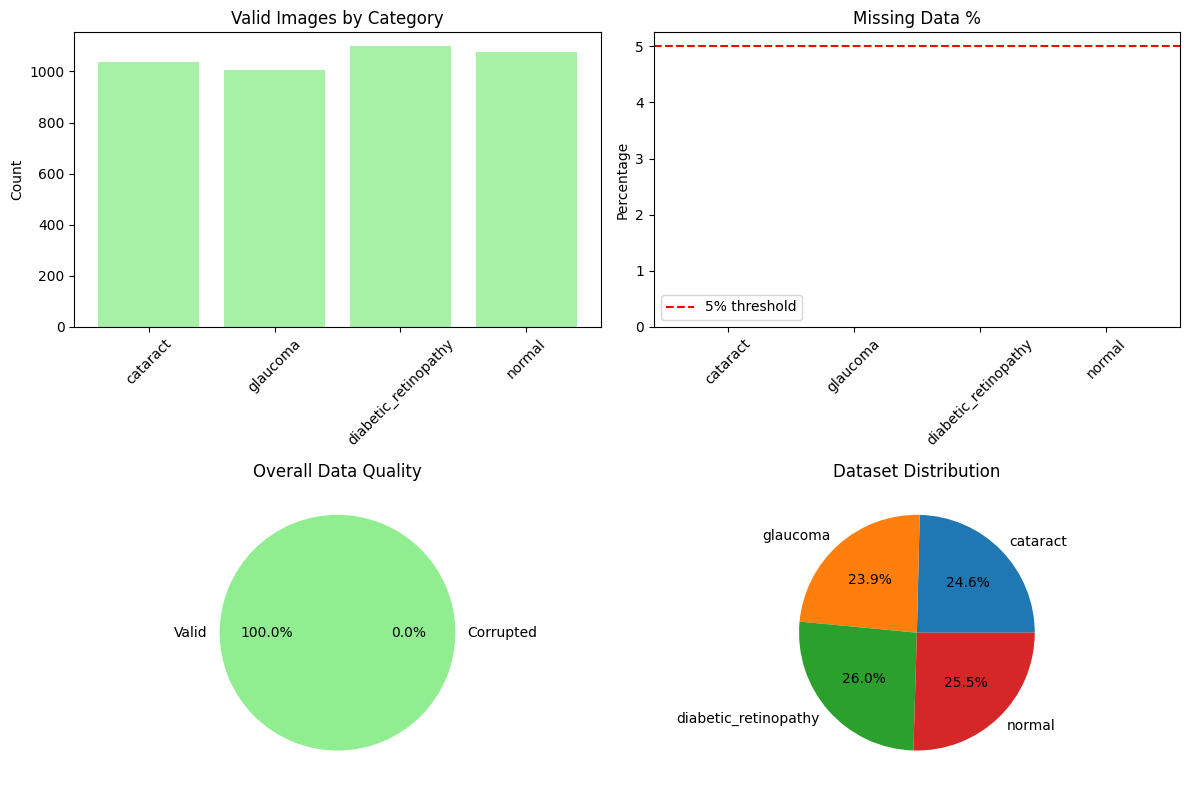

Tasks 1-3 Complete: 0.0% missing data


In [3]:
# Quick visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# 1. Dataset distribution
ax1.bar(df['Category'], df['Valid_Images'], color='lightgreen', alpha=0.8)
ax1.set_title('Valid Images by Category')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Missing data percentage
ax2.bar(df['Category'], df['Missing_%'], color='coral', alpha=0.8)
ax2.set_title('Missing Data %')
ax2.set_ylabel('Percentage')
ax2.axhline(y=5, color='red', linestyle='--', label='5% threshold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# 3. Data quality pie chart
valid_total = df['Valid_Images'].sum()
ax3.pie([valid_total, total_corrupted], labels=['Valid', 'Corrupted'], 
        autopct='%1.1f%%', colors=['lightgreen', 'coral'])
ax3.set_title('Overall Data Quality')

# 4. Category proportions
ax4.pie(df['Valid_Images'], labels=df['Category'], autopct='%1.1f%%')
ax4.set_title('Dataset Distribution')

plt.tight_layout()
plt.show()

print(f"Tasks 1-3 Complete: {overall_missing:.1f}% missing data")

In [4]:
# Task 4-5: Feature Engineering - Extract key features
print("\n" + "="*60)
print("TASK 4-5: FEATURE ENGINEERING")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

IMG_SIZE = 64
features, labels = [], []
feature_names = []

print("Extracting features from images...")

for category in categories:
    category_path = os.path.join(dataset_path, category)
    category_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Processing {category}: {len(category_files)} images")
    
    for fname in category_files[:50]: 
        fpath = os.path.join(category_path, fname)
        try:
            img = Image.open(fpath).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img)
            
            # Color features
            mean_rgb = arr.mean(axis=(0,1))  # Mean RGB values
            std_rgb = arr.std(axis=(0,1))   # Standard deviation RGB
            
            # Simple texture features 
            gray = np.mean(arr, axis=2)  # Convert to grayscale
            edges = np.abs(np.diff(gray, axis=0)).sum() + np.abs(np.diff(gray, axis=1)).sum()
            
            # Brightness and contrast
            brightness = np.mean(gray)
            contrast = np.std(gray)
            
            # Combine features
            feature_vector = np.concatenate([
                mean_rgb,      # 3 features
                std_rgb,       # 3 features  
                [edges, brightness, contrast]  # 3 features
            ])
            
            features.append(feature_vector)
            labels.append(category)
            
        except Exception as e:
            continue

features = np.array(features)
labels = np.array(labels)

print(f"\nFeature Extraction Results:")
print(f"   Features extracted: {features.shape[1]} per image")
print(f"   Total samples: {features.shape[0]}")
print(f"   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]")

# Feature names for interpretation
feature_names = ['R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std', 'edges', 'brightness', 'contrast']

print(f"\nFeature engineering complete!")
print(f"   Categories: {np.unique(labels)}")
print(f"   Samples per category: {[np.sum(labels == cat) for cat in np.unique(labels)]}")


TASK 4-5: FEATURE ENGINEERING
Extracting features from images...
Processing cataract: 1038 images
Extracting features from images...
Processing cataract: 1038 images
Processing glaucoma: 1007 images
Processing glaucoma: 1007 images
Processing diabetic_retinopathy: 1098 images
Processing normal: 1074 images
Processing diabetic_retinopathy: 1098 images
Processing normal: 1074 images

Feature Extraction Results:
   Features extracted: 9 per image
   Total samples: 200
   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]

Feature engineering complete!
   Categories: ['cataract' 'diabetic_retinopathy' 'glaucoma' 'normal']
   Samples per category: [np.int64(50), np.int64(50), np.int64(50), np.int64(50)]

Feature Extraction Results:
   Features extracted: 9 per image
   Total samples: 200
   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]

Feature engineering complete!
   Categories: ['cataract' 'diabetic_ret

In [5]:
# Task 6: Evaluate feature impact
print("\n" + "="*60)
print("TASK 6: FEATURE IMPACT EVALUATION")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=50, random_state=42)
scores = cross_val_score(clf, features, labels, cv=3)

print(f"\nCross-Validation Results:")
print(f"   Individual fold scores: {scores}")
print(f"   Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Feature importance analysis
clf.fit(features, labels)
feature_importance = clf.feature_importances_

print(f"\n Feature Importance Ranking:")
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (name, importance) in enumerate(importance_pairs):
    print(f"   {i+1:2d}. {name:12s}: {importance:.3f}")

print(f"\nTask 6 Complete:")
print(f"   Model accuracy: {scores.mean():.1%}")
print(f"   Top features: {importance_pairs[0][0]}, {importance_pairs[1][0]}, {importance_pairs[2][0]}")
print("="*60)


TASK 6: FEATURE IMPACT EVALUATION
Training Random Forest classifier...

Cross-Validation Results:
   Individual fold scores: [0.55223881 0.53731343 0.54545455]
   Mean accuracy: 0.545 ± 0.006

 Feature Importance Ranking:
    1. R_std       : 0.143
    2. edges       : 0.129
    3. G_std       : 0.117
    4. contrast    : 0.112
    5. B_mean      : 0.106
    6. G_mean      : 0.104
    7. R_mean      : 0.104
    8. B_std       : 0.095
    9. brightness  : 0.091

Task 6 Complete:
   Model accuracy: 54.5%
   Top features: R_std, edges, G_std


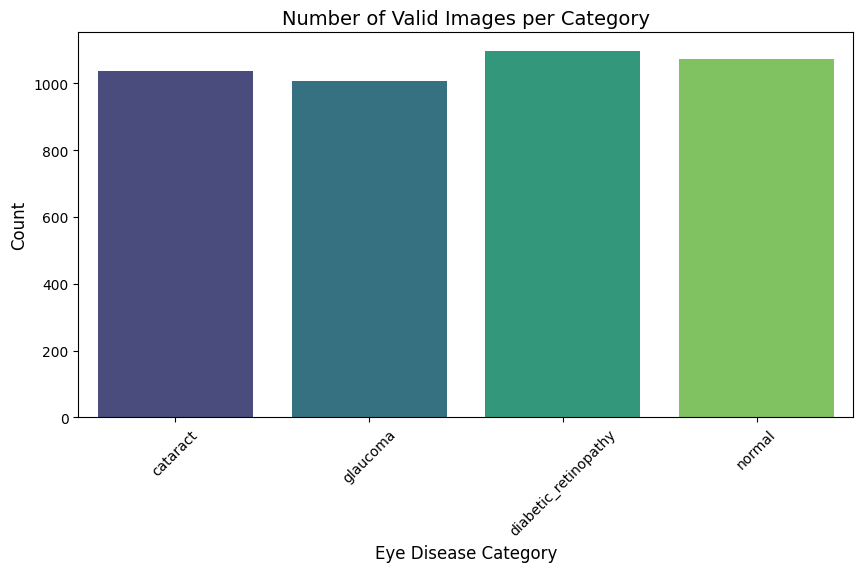

In [6]:
# Additional dataset visualization - Distribution by category
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Category', y='Valid_Images', palette='viridis')
plt.title('Number of Valid Images per Category', fontsize=14)
plt.xlabel('Eye Disease Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

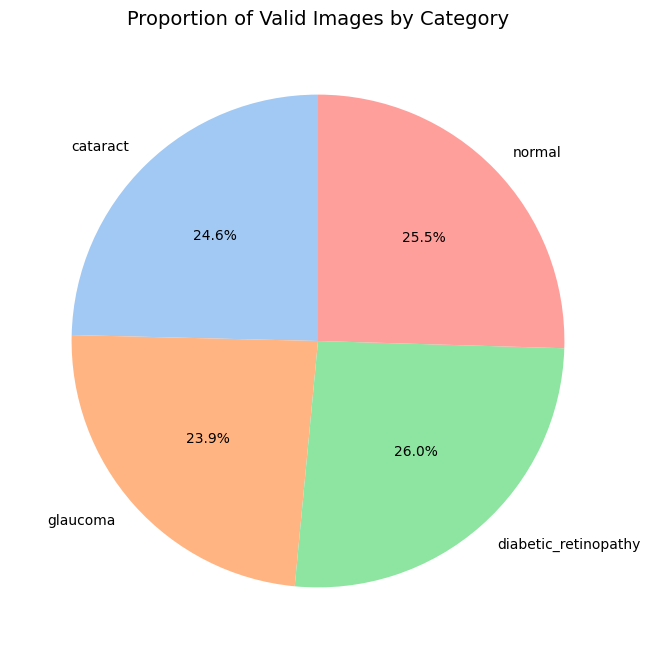

In [7]:
# Pie chart showing proportions of valid images
plt.figure(figsize=(8, 8))
plt.pie(df['Valid_Images'], 
        labels=df['Category'], 
        autopct='%1.1f%%', 
        startangle=90,
        colors=sns.color_palette('pastel'))
plt.title('Proportion of Valid Images by Category', fontsize=14)
plt.show()

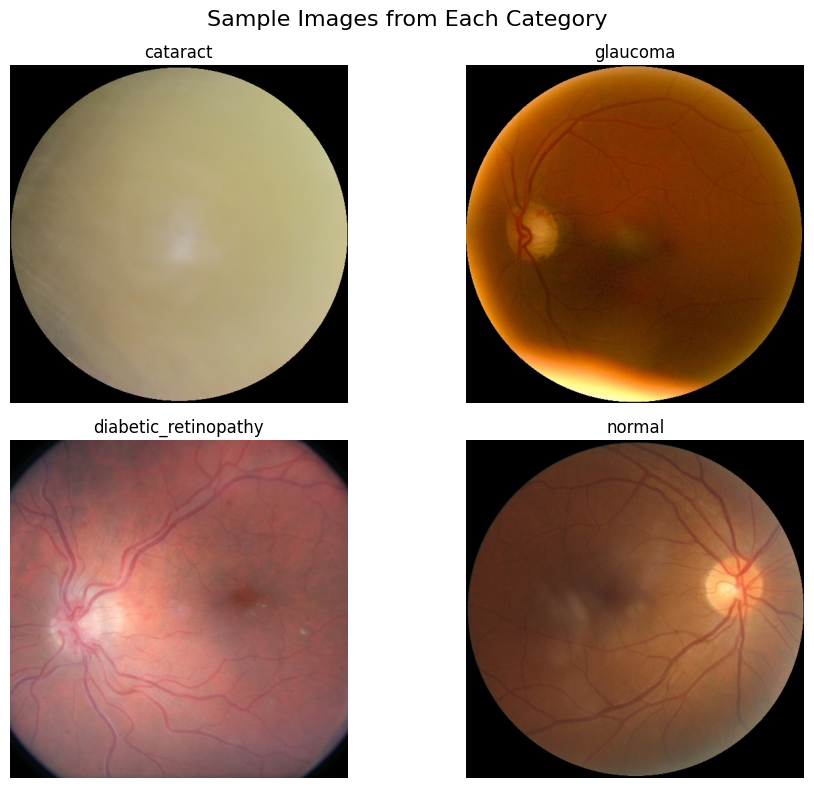

In [8]:
# Sample images from each category
import cv2

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, category in enumerate(categories[:4]):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        img_path = os.path.join(category_path, image_files[0])
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i//2, i%2].imshow(img_rgb)
                axes[i//2, i%2].set_title(category, fontsize=12)
                axes[i//2, i%2].axis('off')
        except Exception as e:
            axes[i//2, i%2].text(0.5, 0.5, f'Error loading\n{category}', 
                                ha='center', va='center', transform=axes[i//2, i%2].transAxes)
            axes[i//2, i%2].set_title(category, fontsize=12)

plt.suptitle('Sample Images from Each Category', fontsize=16)
plt.tight_layout()
plt.show()

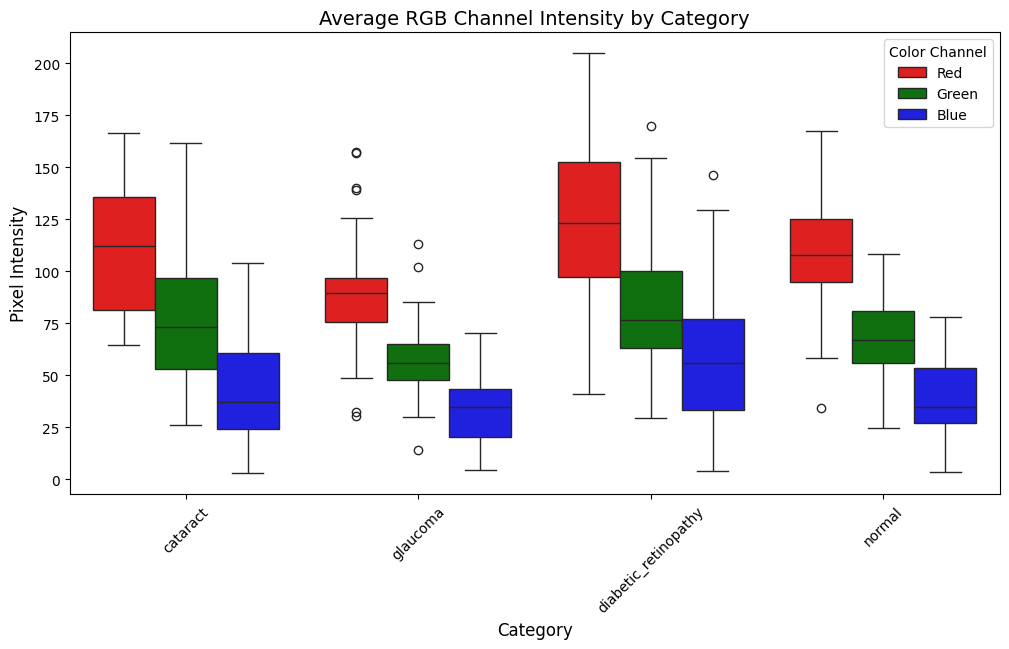

In [9]:
# Compute average RGB channel intensity for each category
channel_data = []

for category in categories:
	category_path = os.path.join(dataset_path, category)
	image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
	# Sample up to 50 images per category for speed
	sample_files = image_files[:50] if len(image_files) > 50 else image_files

	for image_file in sample_files:
		img_path = os.path.join(category_path, image_file)
		try:
			img = cv2.imread(img_path)
			if img is not None:
				img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
				r_mean = img_rgb[:, :, 0].mean()
				g_mean = img_rgb[:, :, 1].mean()
				b_mean = img_rgb[:, :, 2].mean()
				channel_data.append({'category': category, 'channel': 'Red', 'value': r_mean})
				channel_data.append({'category': category, 'channel': 'Green', 'value': g_mean})
				channel_data.append({'category': category, 'channel': 'Blue', 'value': b_mean})
		except Exception:
			continue

channel_df = pd.DataFrame(channel_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=channel_df, x='category', y='value', hue='channel', palette=['red', 'green', 'blue'])
plt.title('Average RGB Channel Intensity by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Pixel Intensity', fontsize=12)
plt.legend(title='Color Channel')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Optimized Transfer Learning for Fast Training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_transfer_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

# Use smaller image size and larger batch for speed
data_dir = "dataset"
IMG_SIZE = (128, 128) 
BATCH_SIZE = 96        

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=8,
    width_shift_range=0.04,
    height_shift_range=0.04,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("🔄 Trying Optimized Transfer Learning approach...")

# Load pre-trained VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Freeze all layers for initial training
base_model.trainable = False

# Build transfer learning model
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Fewer units for speed
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Training (frozen base)...")
history = transfer_model.fit(
    train_generator,
    epochs=5,  
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning: Unfreeze last 4 layers only
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

transfer_model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Fine-tuning...")
history_fine = transfer_model.fit(
    train_generator,
    epochs=4,  
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

model = transfer_model 

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
🔄 Trying Optimized Transfer Learning approach...
🔄 Trying Optimized Transfer Learning approach...
Training (frozen base)...
Training (frozen base)...


/Users/mac/Documents/GitHub/recess-project-y2/Recess-Project-Year-2/eye_disease_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3897 - loss: 1.2983 - precision: 0.5606 - recall: 0.1539
Epoch 1: val_loss improved from inf to 0.99388, saving model to best_transfer_model.h5

Epoch 1: val_loss improved from inf to 0.99388, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 399s 11s/step - accuracy: 0.3921 - loss: 1.2943 - precision: 0.5646 - recall: 0.1557 - val_accuracy: 0.5933 - val_loss: 0.9939 - val_precision: 0.8737 - val_recall: 0.2057
Epoch 2/10
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6357 - loss: 0.9066 - precision: 0.8037 - recall: 0.3534
Epoch 2: val_loss improved from 0.99388 to 0.87963, saving model to best_transfer_model.h5

Epoch 2: val_loss improved from 0.99388 to 0.87963, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 413s 11s/step - accuracy: 0.6363 - loss: 0.9057 - precision: 0.8038 - recall: 0.3545 - val_accuracy: 0.6338 - val_loss: 0.8796 - val_precision: 0.8112 - val_recall: 0.4495
Epoch 3/10
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6933 - loss: 0.7785 - precision: 0.8186 - recall: 0.5073 
Epoch 3: val_loss improved from 0.87963 to 0.80317, saving model to best_transfer_model.h5

Epoch 3: val_loss improved from 0.87963 to 0.80317, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 583s 16s/step - accuracy: 0.6938 - loss: 0.7778 - precision: 0.8190 - recall: 0.5081 - val_accuracy: 0.6468 - val_loss: 0.8032 - val_precision: 0.7843 - val_recall: 0.5232
Epoch 4/10
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7260 - loss: 0.7136 - precision: 0.8194 - recall: 0.5727
Epoch 4: val_loss improved from 0.80317 to 0.77866, saving model to best_transfer_model.h5

Epoch 4: val_loss improved from 0.80317 to 0.77866, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 341s 9s/step - accuracy: 0.7262 - loss: 0.7129 - precision: 0.8199 - recall: 0.5732 - val_accuracy: 0.6480 - val_loss: 0.7787 - val_precision: 0.7504 - val_recall: 0.5648
Epoch 5/10
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7549 - loss: 0.6310 - precision: 0.8457 - recall: 0.6600
Epoch 5: val_loss improved from 0.77866 to 0.72510, saving model to best_transfer_model.h5

Epoch 5: val_loss improved from 0.77866 to 0.72510, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.7548 - loss: 0.6313 - precision: 0.8455 - recall: 0.6598 - val_accuracy: 0.6980 - val_loss: 0.7251 - val_precision: 0.7971 - val_recall: 0.5886
Epoch 6/10
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7728 - loss: 0.6031 - precision: 0.8453 - recall: 0.6702
Epoch 6: val_loss did not improve from 0.72510
36/36 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.7726 - loss: 0.6033 - precision: 0.8450 - recall: 0.6703 - val_accuracy: 0.6468 - val_loss: 0.7895 - val_precision: 0.6879 - val_recall: 0.5767
Epoch 7/10

Epoch 6: val_loss did not improve from 0.72510
36/36 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.7726 - loss: 0.6033 - precision: 0.8450 - recall: 0.6703 - val_accuracy: 0.6468 - val_loss: 0.7895 - val_precision: 0.6879 - val_recall: 0.5767
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7610 - loss: 0.6151 - precision: 0.8284 - recall: 0.6806
Epoch 7: val_loss did not improve from 0.72510
36

36/36 ━━━━━━━━━━━━━━━━━━━━ 392s 11s/step - accuracy: 0.5574 - loss: 1.4187 - precision: 0.6248 - recall: 0.4271 - val_accuracy: 0.7384 - val_loss: 0.6692 - val_precision: 0.8145 - val_recall: 0.6421
Epoch 2/8
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 618s/step - accuracy: 0.7934 - loss: 0.5387 - precision: 0.8362 - recall: 0.7462   
Epoch 2: val_loss improved from 0.66924 to 0.47811, saving model to best_transfer_model.h5

Epoch 2: val_loss improved from 0.66924 to 0.47811, saving model to best_transfer_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 21920s 626s/step - accuracy: 0.7934 - loss: 0.5379 - precision: 0.8360 - recall: 0.7464 - val_accuracy: 0.7979 - val_loss: 0.4781 - val_precision: 0.8333 - val_recall: 0.7551
Epoch 3/8
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8322 - loss: 0.4331 - precision: 0.8593 - recall: 0.8038
Epoch 3: val_loss did not improve from 0.47811
36/36 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.8321 - loss: 0.4329 - precision: 0.8593 - recall: 0.8038 - val_accuracy: 0.7765 - val_loss: 0.5034 - val_precision: 0.8092 - val_recall: 0.7515
Epoch 4/8

Epoch 3: val_loss did not improve from 0.47811
36/36 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.8321 - loss: 0.4329 - precision: 0.8593 - recall: 0.8038 - val_accuracy: 0.7765 - val_loss: 0.5034 - val_precision: 0.8092 - val_recall: 0.7515
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8334 - loss: 0.4032 - precision: 0.8610 - recall: 0.8055
Epoch 4: val_loss did not improve from 0.47811


In [16]:
# Further fine-tuning after initial training is complete
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Unfreeze more layers for deeper fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile with a very low learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
 )

# Fine-tuning callbacks
finetune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
 ]

print("Starting fine-tuning after initial training...")
history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=finetune_callbacks,
    verbose=1
)

Starting fine-tuning after initial training...
Epoch 1/5
Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.8467 - loss: 0.3970 - precision: 0.8686 - recall: 0.8142 - val_accuracy: 0.7907 - val_loss: 0.4717 - val_precision: 0.8207 - val_recall: 0.7622 - learning_rate: 1.0000e-05
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.8467 - loss: 0.3970 - precision: 0.8686 - recall: 0.8142 - val_accuracy: 0.7907 - val_loss: 0.4717 - val_precision: 0.8207 - val_recall: 0.7622 - learning_rate: 1.0000e-05
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.8465 - loss: 0.3795 - precision: 0.8706 - recall: 0.8240 - val_accuracy: 0.7705 - val_loss: 0.5160 - val_precision: 0.7906 - val_recall: 0.7586 - learning_rate: 1.0000e-05
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.8465 - loss: 0.3795 - precision: 0.8706 - recall: 0.8240 - val_accuracy: 0.7705 - val_loss: 0.5160 - val_precision: 0.7906 - val_recall: 0.7586 - learning_rate: 1.0000e-05

In [24]:
# Save the fine-tuned model as best-transfer-1.h5
model.save('best-transfer-1.h5')
print('Model saved as best-transfer-1.h5')

Model saved as best-transfer-1.h5


In [25]:
# Advanced fine-tuning: Unfreeze more layers, lower LR, stronger regularization, save model as best-transfer-2.h5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add L2 regularization to all Dense layers
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(0.003)

model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
 )

advanced_callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint('best-transfer-2.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
 ]

print("Starting advanced fine-tuning for best-transfer-2...")
history_advanced = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=advanced_callbacks,
    verbose=1
)

Starting advanced fine-tuning for best-transfer-2...
Epoch 1/12
Epoch 1/12
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8480 - loss: 0.3874 - precision: 0.8688 - recall: 0.8171
Epoch 1: val_accuracy improved from -inf to 0.77646, saving model to best-transfer-2.h5

Epoch 1: val_accuracy improved from -inf to 0.77646, saving model to best-transfer-2.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 341s 9s/step - accuracy: 0.8481 - loss: 0.3874 - precision: 0.8689 - recall: 0.8172 - val_accuracy: 0.7765 - val_loss: 0.4916 - val_precision: 0.7992 - val_recall: 0.7574 - learning_rate: 5.0000e-06
Epoch 2/12
Epoch 2/12
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8526 - loss: 0.3764 - precision: 0.8739 - recall: 0.8245
Epoch 2: val_accuracy improved from 0.77646 to 0.77883, saving model to best-transfer-2.h5

Epoch 2: val_accuracy improved from 0.77646 to 0.77883, saving model to best-transfer-2.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.8526 - loss: 0.3763 - precision: 0.8740 - recall: 0.8245 - val_accuracy: 0.7788 - val_loss: 0.4880 - val_precision: 0.8050 - val_recall: 0.7610 - learning_rate: 5.0000e-06
Epoch 3/12
Epoch 3/12
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8505 - loss: 0.3782 - precision: 0.8723 - recall: 0.8297
Epoch 3: val_accuracy did not improve from 0.77883
36/36 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.8506 - loss: 0.3782 - precision: 0.8724 - recall: 0.8297 - val_accuracy: 0.7693 - val_loss: 0.5112 - val_precision: 0.7943 - val_recall: 0.7574 - learning_rate: 5.0000e-06
Epoch 4/12

Epoch 3: val_accuracy did not improve from 0.77883
36/36 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.8506 - loss: 0.3782 - precision: 0.8724 - recall: 0.8297 - val_accuracy: 0.7693 - val_loss: 0.5112 - val_precision: 0.7943 - val_recall: 0.7574 - learning_rate: 5.0000e-06
Epoch 4/12
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8565 - loss: 0

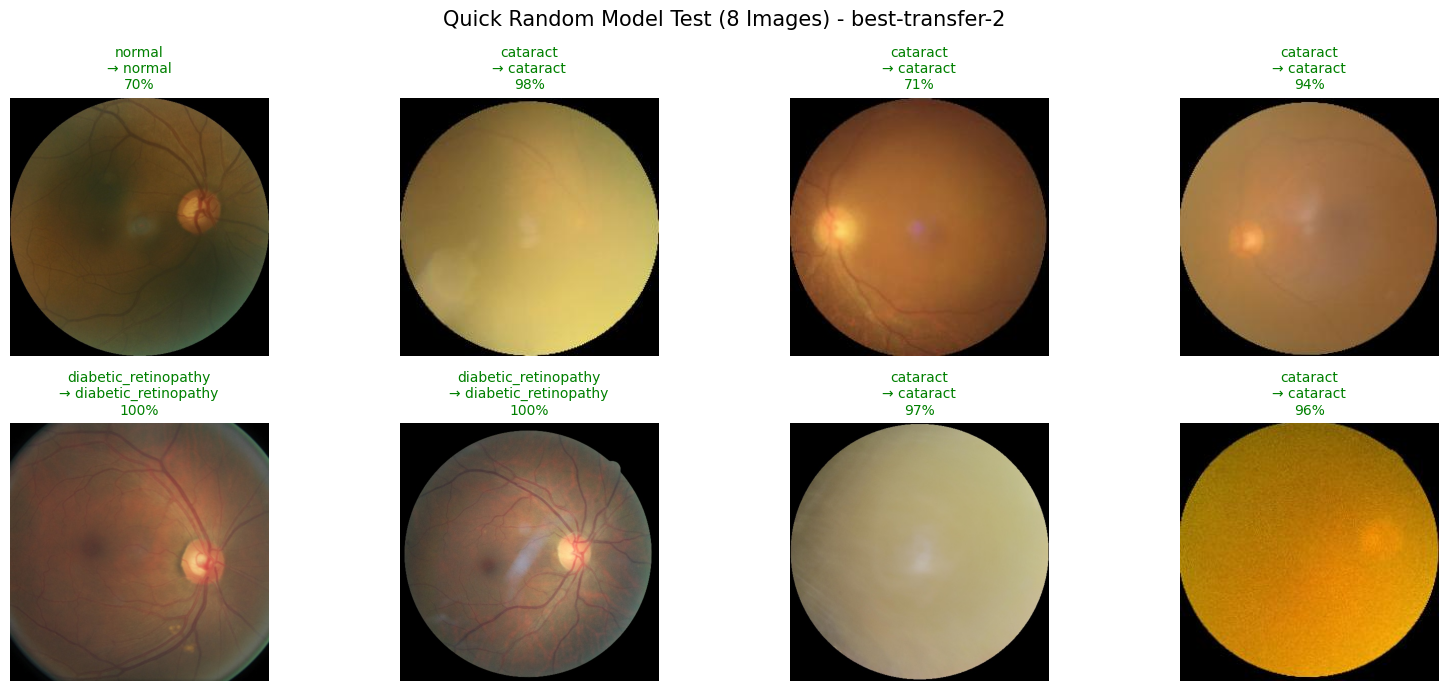

Tested 8 images | Accuracy: 100.0% | Precision: 1.00 | Recall: 1.00 | F1: 1.00 | Avg Conf: 90.7%


In [29]:
# Fast Random Model Testing (8 Images, Concise Output) using latest saved model (best-transfer-2.h5)
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Ensure categories and dataset_path are defined
try:
    categories
except NameError:
    dataset_path = "dataset"
    categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Load the latest model
latest_model = load_model('best-transfer-2.h5')

# Get class labels and prepare for testing
class_labels = list(train_generator.class_indices.keys())

def predict_image(img_path):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)  # Match training size
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = latest_model.predict(img_array, verbose=0)
        predicted_class = class_labels[np.argmax(predictions)]
        confidence = np.max(predictions) * 100
        return predicted_class, confidence
    except Exception as e:
        return None, None

# Collect all image paths and shuffle them
all_images = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in image_files[:20]:  # Fewer per category for speed
        all_images.append((os.path.join(category_path, img_file), category))

random.shuffle(all_images)
selected_images = all_images[:8]  # Test on 8 random images

true_labels = []
predicted_labels = []
confidences = []

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, (img_path, true_category) in enumerate(selected_images):
    try:
        predicted, confidence = predict_image(img_path)
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_rgb = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        axes[i].imshow(img_rgb)
        if predicted is not None:
            color = 'green' if predicted.lower() == true_category.lower() else 'red'
            axes[i].set_title(f"{true_category}\n→ {predicted}\n{confidence:.0f}%", color=color, fontsize=10)
            true_labels.append(true_category)
            predicted_labels.append(predicted)
            confidences.append(confidence)
        else:
            axes[i].set_title(f"{true_category}\n→ Error", color='red', fontsize=10)
        axes[i].axis('off')
    except Exception:
        axes[i].text(0.5, 0.5, 'Error', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].axis('off')

plt.suptitle('Quick Random Model Test (8 Images) - best-transfer-2', fontsize=15)
plt.tight_layout()
plt.show()

# Metrics summary
if true_labels:
    true_numeric = [class_labels.index(label) for label in true_labels]
    pred_numeric = [class_labels.index(label) for label in predicted_labels]
    accuracy = sum(1 for t, p in zip(true_labels, predicted_labels) if t == p) / len(true_labels)
    precision = precision_score(true_numeric, pred_numeric, average='weighted', zero_division=0)
    recall = recall_score(true_numeric, pred_numeric, average='weighted', zero_division=0)
    f1 = f1_score(true_numeric, pred_numeric, average='weighted', zero_division=0)
    avg_confidence = np.mean(confidences)
    print(f"Tested {len(true_labels)} images | Accuracy: {accuracy*100:.1f}% | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | Avg Conf: {avg_confidence:.1f}%")
else:
    print("No valid predictions made.")

In [13]:
%pip install icrawler

# Auto-scrape images from the internet for each disease category using icrawler
from icrawler.builtin import GoogleImageCrawler
import os

# Set up output directory for scraped images
scrape_dir = 'scraped_test_images'
os.makedirs(scrape_dir, exist_ok=True)

# Define categories and number of images per category
categories_to_scrape = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal eye']
images_per_category = 8

for category in categories_to_scrape:
    category_dir = os.path.join(scrape_dir, category.replace(' ', '_'))
    os.makedirs(category_dir, exist_ok=True)
    print(f"Scraping images for: {category}")
    crawler = GoogleImageCrawler(storage={'root_dir': category_dir})
    crawler.crawl(keyword=category + ' eye', max_num=images_per_category)

print("Image scraping complete. Images saved in scraped_test_images/.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.4 MB ? eta -:--:--Downloading lxml-6.0.0-cp312-cp312-macosx_10_13_universal2.whl (8.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 614.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 614.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [icrawler]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [icrawler]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Scraping images for: cataract
Scraping images for: cataract
Scraping images for: diabetic retinopathy
Scraping images for: diabetic retinopathy
Scraping images for: glaucoma
Scraping images for: glaucoma


ERROR:downloader:Response status code 403, file https://carolinaeyecare.com/wp-content/uploads/2022/11/What-Does-Glaucoma-Look-Like_.jpg


Scraping images for: normal eye
Image scraping complete. Images saved in scraped_test_images/.
Image scraping complete. Images saved in scraped_test_images/.


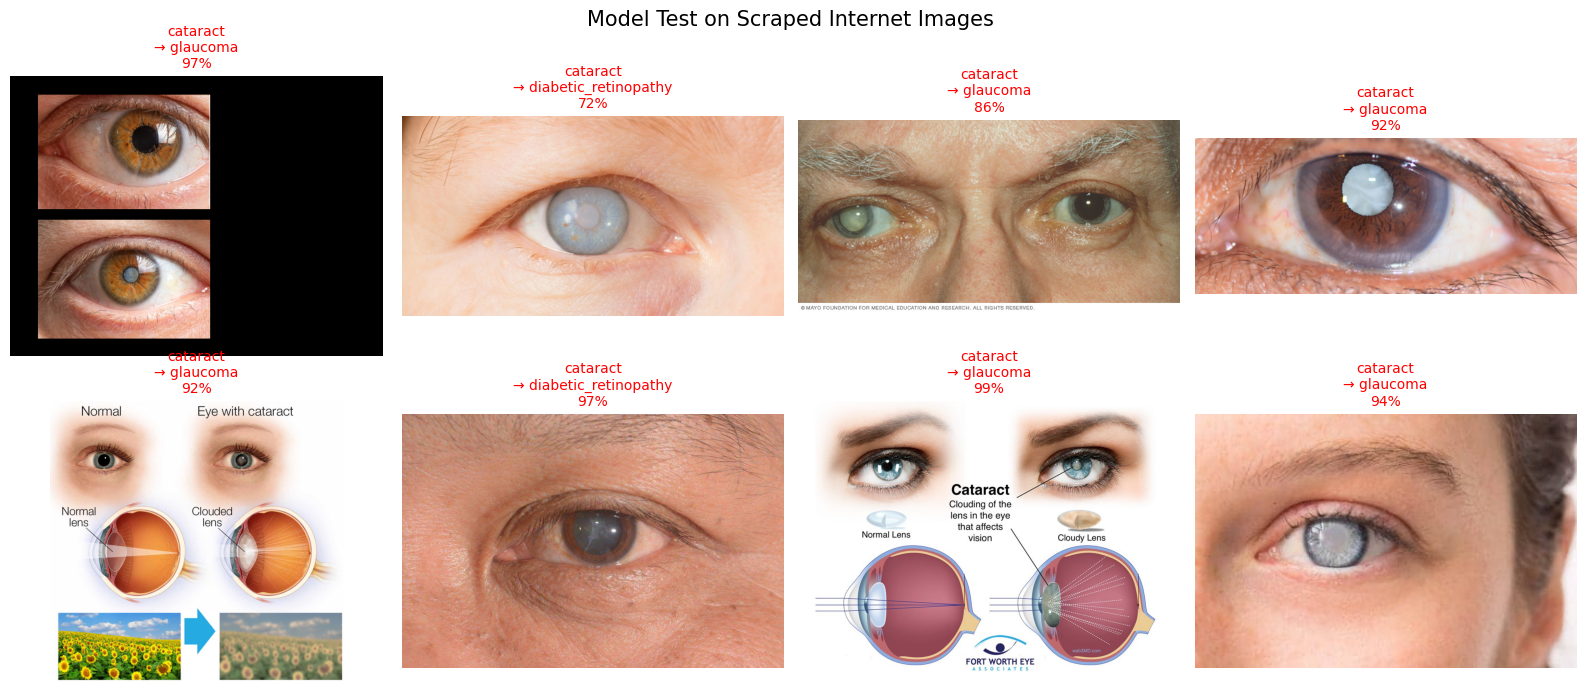

In [ ]:
# Test the scraped images using the latest saved model (best-transfer-2.h5)
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

scrape_dir = 'scraped_test_images'
categories_to_scrape = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal eye']

# Load the latest model
latest_model = load_model('best-transfer-2.h5')

test_images = []
test_labels = []
for category in categories_to_scrape:
    category_dir = os.path.join(scrape_dir, category.replace(' ', '_'))
    image_files = glob.glob(os.path.join(category_dir, '*'))
    for img_path in image_files:
        test_images.append(img_path)
        test_labels.append(category)

class_labels = list(train_generator.class_indices.keys())

def predict_scraped_image(img_path):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = latest_model.predict(img_array, verbose=0)
        predicted_class = class_labels[np.argmax(predictions)]
        confidence = np.max(predictions) * 100
        return predicted_class, confidence
    except Exception as e:
        return None, None

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, (img_path, true_category) in enumerate(zip(test_images[:8], test_labels[:8])):
    predicted, confidence = predict_scraped_image(img_path)
    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    axes[i].imshow(img_rgb)
    if predicted is not None:
        color = 'green' if predicted.lower() == true_category.lower() else 'red'
        axes[i].set_title(f"{true_category}\n→ {predicted}\n{confidence:.0f}%", color=color, fontsize=10)
    else:
        axes[i].set_title(f"{true_category}\n→ Error", color='red', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Model Test on Scraped Internet Images (best-transfer-2)', fontsize=15)
plt.tight_layout()
plt.show()